# Active Learning  and SLIC Super Pixels.

## Introduction: 

In this notebook SLIC superpixels [2] together with several descriptors and Active Learning  techniques [1] will be applied over a known Horse Dataset[3]. We  follow the work of [4], first we extract Super Pixels regions, then we build a dataset using different filters over the images and gather togheter for each individual region first order statistics; subsequently we used Active Learning to build a model for image segmentation. Finally, we compare the performance of different estrategies such as random sampling and uncertainty sampling, using f-score and error functions. 

## SLIC Super Pixels: 

SLIC (Simple Linear Iterative Clustering) is an algorithm to cluster pixels combining five-dimensional color and image plane space to efficiently generate compact, nearly uniform superpixels. One of its best features is the low-cost / high quality segmentation it has [5]. Here is some code following [6] and [7] applyied to our particular dataset. 

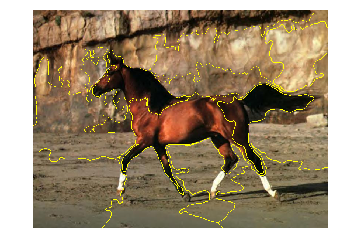

In [8]:
#CODE for SLIC superpixel extraction and mark boundaries. 
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse
#Importing packages for interactive widgets
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

# loop over the number of segments
def slic_demo(numSegments):
    # load the image and convert it to a floating point data type
    image = img_as_float(io.imread("horse/rgb/horse001.jpg"))
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(image, n_segments = numSegments, sigma = 5)
    # show the output of SLIC
    fig = plt.figure("Superpixels -- %d segments" % (numSegments))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
     # show the plots
    plt.show()
slider = widgets.IntSlider(min=10, max=500, step=50, value=15)
widgets.interactive(slic_demo,numSegments=slider)

As we can see from each of these regions edge detection is done very efficiently. However given the difficulty of the problem it would be important to keep the right size for the regions since if they are too little they may be hard to classify when similar colors appear in the background. 

Now  we want to access each of these regions separately to extract the descriptors but limited by the region. To do so, we used the mask that we get from the SLIC, and perform the first order statistics calculations for gathering. This process might take several minutes and even hours, so we write into a file the dataset extracted for future usage. If you already ran this, just make sure to keep the text file available and skip this snnipet of code. 

In [4]:
# This code has all the predefined functions. 
# Importing packages:
from skimage.segmentation import slic,mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import regionprops
from skimage.color import rgb2hsv
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit,KFold,ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import svm
import cv2 as cv 
import os,glob, shutil
import numpy as np
import matplotlib.pyplot as plt
def preprocessing(imagename, labeling,n_segments,sigma):
    # load the image and convert it to a floating point data type
    image= img_as_float(io.imread(imagename))
    #load the image with the labeling
    imlabels= cv.imread(labeling)
    imlabels= cv.resize(imlabels,(image.shape[1],image.shape[0]))
    # Perform slic super pixels segmentations
    segments = slic(image, n_segments = n_segments, sigma = sigma)
    regionpro=regionprops(segments,imlabels[:,:,1])
    prob=np.array([p.mean_intensity/255 for p in regionpro])
    prob = np.insert(prob, 0, [0])
    labels=[0 if i<0.5 else 1 for i in prob]
    return image,segments,labels

def make3d(descriptor):
    if (descriptor.ndim==2):
        dim=1
    else:
        dim=descriptor.shape[2]
    return np.reshape(descriptor, (descriptor.shape[0],descriptor.shape[1],dim))


def compute_polling(plane, segments):
    numsegments = int(np.max(segments)+1)
    fv = np.zeros((5,numsegments))
    fv[3,:] = np.max(plane)
    fv[4,:] = np.min(plane)
    for y in range(plane.shape[0]):
        for x in range(plane.shape[1]):
            L = int(segments[y,x])
            V = plane[y,x]
            fv[0,L] = fv[0,L]+1
            fv[1,L] = fv[1,L]+V
            fv[2,L] = fv[2,L]+V**2
            fv[3,L] = min(fv[3,L],V)
            fv[4,L] = max(fv[4,L],V)
    #for L in range(numsegments):
    fv[1,:] = fv[1,:]/fv[0,:]
    fv[2,:] = fv[2,:]-fv[1,:]**2
    fv[np.isnan(fv)] = 0
    return fv


def build_features(image, segments):
    hsv = rgb2hsv(image)
    h=hsv[:,:,0]/180
    s=hsv[:,:,1]/255
    v=hsv[:,:,2]/255
    ga=cv.GaussianBlur(image,(61,61),8.0)
    laga=cv.Laplacian(ga,cv.CV_64F)
    sobel= cv.Sobel(image,cv.CV_64F,1,0,ksize=3)
    descriptors=[image,h,s,v,ga,laga,sobel]  
    dataset=np.zeros((5,segments.max()+1))
    count=0
    for descriptor in descriptors:
        descriptor = make3d(descriptor)
        for channel in range(0,descriptor.shape[2]):
            plane = descriptor[:,:,channel]
            fv=compute_polling(plane,segments)
            dataset=np.r_[dataset,fv]
    return dataset

def build_dataset(imagespath,labelingpath,n_segments,sigma):
    imlist = glob.glob(os.path.join(imagespath,'*.jpg'))
    data  = np.ndarray((0,80))
    labeling = []
    for im in imlist[0:20]:
        image,segments,labels = preprocessing(im,labelingpath+im[10:],n_segments,sigma)
        dataset = np.transpose(build_features(image,segments))
        data = np.r_[data,dataset]
        labeling += labels
    return data,labeling

def classify(dataset,labels,classifier):
    k = 5
    n_splits=5
    skf = StratifiedKFold(n_splits=n_splits)
    skf_ss = StratifiedShuffleSplit(n_splits=n_splits)
    C=1
    classifiers={"knn":KNeighborsClassifier(n_neighbors=k),"svml":svm.SVC(kernel='linear', C=C)
                 ,"svmr":svm.SVC(kernel='rbf', C=C),
                   "boost":GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                                             max_depth=2, random_state=0)}
    scores={}
    for k in classifier:
        sc = cross_val_score(classifiers[k],dataset,labels,cv=skf)
        sc_f = cross_val_score(classifiers[k],dataset,labels,cv=skf,scoring ='f1')
        sc2 = cross_val_score(classifiers[k],dataset,labels,cv=skf_ss)
        sc2_f = cross_val_score(classifiers[k],dataset,labels,cv=skf_ss,scoring ='f1')
        scores[k] = [sc.mean(),sc.std()]
        scores["shuffling "+ k]=[sc2.mean(),sc2.std()]
        scores["f1 "+ k]=[sc_f.mean(),sc_f.std()]
        scores["Shuffling-f1 "+ k]=[sc2_f.mean(),sc2_f.std()]
    return scores

In [5]:
# Function to extrac features for the whole dataset. Takes long time, 
#so once it is done you can just load the text files. 
def main():
    imagespath = "horse/rgb/"
    labelingpath = "horse/figure_ground/"
    data,labels = build_dataset(imagespath,labelingpath)
    np.savetxt("data1.txt", data)
    np.savetxt("labels1.txt",labels)
    #results=classify(data,labels,["knn","boost"])
    #np.savetxt("results1.txt",results)
main()

### Example: 

In this following example we present supervised approach over 21 examples, mostly for running time purposes and illustration. For scoring we use acuracy and f1-score  cross validation.

In [6]:
imagespath = "horse/rgb/"
labelingpath = "horse/figure_ground/"
data,labels = build_dataset(imagespath,labelingpath,50,5)


In [7]:
classify(data,labels,["knn","boost"])

{'Shuffling-f1 boost': [0.71567375886524831, 0.057857910869722376],
 'Shuffling-f1 knn': [0.46594843065431302, 0.083499753143133737],
 'boost': [0.79824528372662074, 0.061792230306419893],
 'f1 boost': [0.62700728229560454, 0.10405099208139065],
 'f1 knn': [0.3428186960632571, 0.055746817202205333],
 'knn': [0.72037324780849832, 0.043963844673399782],
 'shuffling boost': [0.86966292134831458, 0.024202987897233706],
 'shuffling knn': [0.75505617977528083, 0.030482381946630416]}

We can observe the boosting strategy, with f1 score, come closer to the results presented by  [4], using a similar set-up. However let us run on the complete dataset to confirm this situation. 

In [21]:
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

# libact classes
from libact.base.dataset import Dataset, import_libsvm_sparse
from libact.models import SklearnAdapter
from libact.models import *
from libact.query_strategies import *
from libact.labelers import IdealLabeler


def run(trn_ds, tst_ds, lbr, model, qs, quota):
    E_in, E_out = [], []

    for _ in range(quota):
        # Standard usage of libact objects
        ask_id = qs.make_query()
        X, _ = zip(*trn_ds.data)
        lb = lbr.label(X[ask_id])
        trn_ds.update(ask_id, lb)

        model.train(trn_ds)
        E_in = np.append(E_in, 1 - model.score(trn_ds))
        E_out = np.append(E_out, 1 - model.score(tst_ds))

    return E_in, E_out


def split_train_test(X,y, test_size, n_labeled):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    trn_ds = Dataset(X_train, np.concatenate([y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]))
    tst_ds = Dataset(X_test, y_test)
    fully_labeled_trn_ds = Dataset(X_train, y_train)

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds
def active_learning(data,labels,test_size,n_labeled):
    # Load dataset
    trn_ds, tst_ds, y_train, fully_labeled_trn_ds = split_train_test(data,labels, test_size, n_labeled)
    trn_ds2 = copy.deepcopy(trn_ds)
    lbr = IdealLabeler(fully_labeled_trn_ds)

    quota = len(y_train) - n_labeled    # number of samples to query

    # Comparing UncertaintySampling strategy with RandomSampling.
    # model is the base learner, e.g. LogisticRegression, SVM ... etc.
    clf=SklearnProbaAdapter(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=2, random_state=0))
    qs = UncertaintySampling(trn_ds, method='lc', model=clf)
    model = clf
    E_in_1, E_out_1 = run(trn_ds, tst_ds, lbr, model, qs, quota)

    qs2 = RandomSampling(trn_ds2)
    model = clf
    E_in_2, E_out_2 = run(trn_ds2, tst_ds, lbr, model, qs2, quota)

    # Plot the learning curve of UncertaintySampling to RandomSampling
    # The x-axis is the number of queries, and the y-axis is the corresponding
    # error rate.
    query_num = np.arange(1, quota + 1)
    plt.plot(query_num, E_in_1, 'b', label='qs Ein')
    plt.plot(query_num, E_in_2, 'r', label='random Ein')
    plt.plot(query_num, E_out_1, 'g', label='qs Eout')
    plt.plot(query_num, E_out_2, 'k', label='random Eout')
    plt.xlabel('Number of Queries')
    plt.ylabel('Error')
    plt.title('Experiment Result')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
    plt.show()

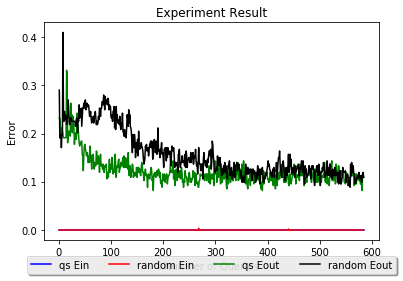

In [22]:
test_size = 0.33 # the percentage of samples in the dataset that will be
                    # randomly selected and assigned to the test set
n_labeled = 10 # number of samples that are initially labeled
active_learning(data,labels,test_size,n_labeled)


# References: 

[1] Y.-Y. Yang, S.-C. Lee, Y.-A. Chung, T.-E. Wu, H.-T. Lin. 2015. library:libact. Available at: http://libact.readthedocs.io/

[2] Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014) http://dx.doi.org/10.7717/peerj.453

[3] https://avaminzhang.wordpress.com/2012/12/07/%E3%80%90dataset%E3%80%91weizmann-horses/

[4] K. Konyushkova and R. Sznitman and P. Fua, Introducing Geometry in Active Learning for Image Segmentation,CoRR, abs/1508.04955, 2015,http://arxiv.org/abs/1508.04955. 

[5] Achanta, R., Shaji, A., Smith, K., Lucchi, A., Fua, P., & Süsstrunk, S. (2010). Slic superpixels (No. EPFL-REPORT-149300).

[6] Adrian Rosebrock: http://www.pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/